In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
#import quandl

import cvxportfolio as cp

获取股票价格数据及无风险利率

In [2]:
from zipline.research import returns
from zipline.data.treasuries_cn import get_treasury_data

In [3]:
# 注意无风险利率选择一年期，然后除每年交易天数244

tickers = ['300001', '000333', '600771', '600645']
start ='2016-01-01'
end ='2018-05-25'
rets = returns(tickers, start, end)

[2018-05-28 21:48:10.113782] INFO: zipline.finance.metrics.tracker: 模拟1个交易日
首个开盘时间: 2018-05-25 01:31:00+00:00
最后收盘时间: 2018-05-25 07:00:00+00:00


In [4]:
rets.columns = [c.symbol for c in rets.columns] # 转为str

In [5]:
rets['cash'] = get_treasury_data(start, end)['1year'] / 244.0

In [6]:
rets.head()

,300001,000333,600771,600645,cash
2016-01-04 00:00:00+00:00,-0.099644,-0.094482,0.0,-0.099985,0.000096
2016-01-05 00:00:00+00:00,-0.055950,0.054211,0.0,-0.032473,0.000097
2016-01-06 00:00:00+00:00,0.020717,0.008265,0.0,0.047871,0.000097
2016-01-07 00:00:00+00:00,-0.100167,-0.080731,0.0,-0.099966,0.000097
2016-01-08 00:00:00+00:00,-0.021627,0.026527,0.0,0.065368,0.000097


We compute rolling estimates of the first and second moments of the returns using a window of 250 days. We shift them by one unit (so at every day we present the optimizer with only past data).

计算滚动244天

In [7]:
r_hat = rets.rolling(window=244, min_periods=244).mean().shift(1).dropna()
Sigma_hat = rets.rolling(window=244, min_periods=244, closed='neither').cov().dropna()

r_hat.tail()

,300001,000333,600771,600645,cash
2018-05-21 00:00:00+00:00,-0.001113,0.002156,0.001664,0.000444,0.000141
2018-05-22 00:00:00+00:00,-0.000842,0.002035,0.001665,0.000487,0.000141
2018-05-23 00:00:00+00:00,-0.000693,0.001857,0.001810,0.000819,0.000141
2018-05-24 00:00:00+00:00,-0.000614,0.001780,0.001805,0.000991,0.000141
2018-05-25 00:00:00+00:00,-0.000689,0.001733,0.001766,0.000936,0.000141


In [8]:
Sigma_hat.tail()

300001        000333        600771  \
2018-05-25 00:00:00+00:00 300001  3.816810e-04  4.955195e-05  6.266618e-05   
                          000333  4.955195e-05  4.643027e-04  5.308990e-05   
                          600771  6.266618e-05  5.308990e-05  3.135805e-04   
                          600645  1.308376e-04 -1.406242e-05  3.150643e-05   
                          cash   -4.692746e-09  9.682933e-09 -1.145340e-08   

                                        600645          cash  
2018-05-25 00:00:00+00:00 300001  1.308376e-04 -4.692746e-09  
                          000333 -1.406242e-05  9.682933e-09  
                          600771  3.150643e-05 -1.145340e-08  
                          600645  7.150218e-04 -5.462981e-09  
                          cash   -5.462981e-09  6.828097e-11

Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

定义交易成本及持有成本
- 标量：所有时间及资产一个固定值
- 序列：特定资产固定值
- 数据框：随时间及资产而变化的值

In [9]:
tcost_model=cp.TcostModel(half_spread=10E-4)
hcost_model=cp.HcostModel(borrow_costs=1E-4)

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [10]:
risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5., 1., 1.
leverage_limit = cp.LeverageLimit(1)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
                                constraints=[leverage_limit])

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

运行回测，返回结果对象。调用统计描述方法获取基础统计信息。

In [11]:
rets = rets.loc[r_hat.index] # 与r_hat时间同步

In [12]:
market_sim=cp.MarketSimulator(rets, [tcost_model, hcost_model], cash_key='cash') 
init_portfolio = pd.Series(index=rets.columns, data=250000.)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time=start,  end_time=end,  
                               policies=[spo_policy, cp.Hold()])
results[0].summary()

Number of periods                                     339
Initial timestamp               2017-01-03 00:00:00+00:00
Final timestamp                 2018-05-25 00:00:00+00:00
Portfolio return (%)                               31.596
Excess return (%)                                  28.191
Excess risk (%)                                    18.959
Sharpe ratio                                        1.489
Max. drawdown                                      13.286
Turnover (%)                                       55.781
Average policy time (sec)                           0.023
Average simulator time (sec)                        0.003


In [16]:
results[1].summary()

Number of periods                                     339
Initial timestamp               2017-01-03 00:00:00+00:00
Final timestamp                 2018-05-25 00:00:00+00:00
Portfolio return (%)                               17.464
Excess return (%)                                  14.059
Excess risk (%)                                    15.488
Sharpe ratio                                        0.909
Max. drawdown                                      14.403
Turnover (%)                                        0.000
Average policy time (sec)                           0.000
Average simulator time (sec)                        0.003


The total value of the portfolio in time.

投资组合总值时间序列

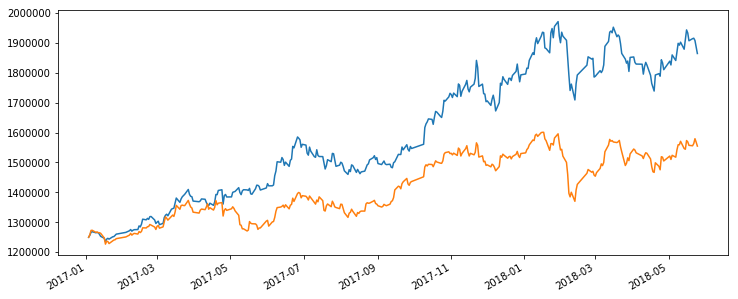

In [14]:
results[0].v.plot(figsize=(12,5))
results[1].v.plot(figsize=(12,5))

The weights vector of the portfolio in time.

投资组合权重矢量时间序列

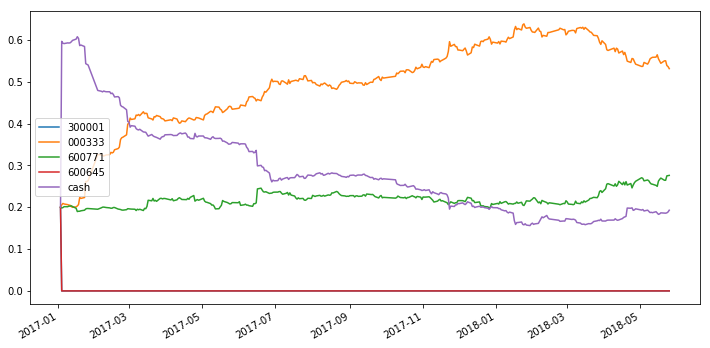

In [15]:
results[0].w.plot(figsize=(12,6))

In [17]:
result = results[0]

In [18]:
result.profit

613950.4461138877

In [20]:
result.w.tail()

,300001,000333,600771,600645,cash
2018-05-21 00:00:00+00:00,3.188864e-09,0.549728,0.264408,6.862404e-08,0.185864
2018-05-22 00:00:00+00:00,2.581116e-09,0.549911,0.264346,7.358363e-08,0.185743
2018-05-23 00:00:00+00:00,2.048447e-09,0.538615,0.274871,8.641588e-08,0.186514
2018-05-24 00:00:00+00:00,1.002555e-09,0.536032,0.275350,9.275207e-08,0.188618
2018-05-25 00:00:00+00:00,3.426895e-09,0.531138,0.276032,9.373036e-08,0.192830


In [22]:
result.leverage.tail()

2018-05-21 00:00:00+00:00    1.0
2018-05-22 00:00:00+00:00    1.0
2018-05-23 00:00:00+00:00    1.0
2018-05-24 00:00:00+00:00    1.0
2018-05-25 00:00:00+00:00    1.0
dtype: float64

In [24]:
result.growth_rates.tail()

2018-05-18 00:00:00+00:00    0.003699
2018-05-21 00:00:00+00:00    0.000780
2018-05-22 00:00:00+00:00   -0.004015
2018-05-23 00:00:00+00:00   -0.011090
2018-05-24 00:00:00+00:00   -0.011915
dtype: float64

In [25]:
result.annual_growth_rate

0.297892763707177

In [26]:
result.annual_return

34.70173309892382

In [28]:
result.returns.tail()

2018-05-18 00:00:00+00:00    0.003706
2018-05-21 00:00:00+00:00    0.000780
2018-05-22 00:00:00+00:00   -0.004007
2018-05-23 00:00:00+00:00   -0.011029
2018-05-24 00:00:00+00:00   -0.011845
dtype: float64

In [29]:
import logging

In [30]:
market_sim = cp.MarketSimulator(
    rets, [tcost_model, hcost_model], cash_key='cash')
init_portfolio = pd.Series(index=rets.columns, data=10000.)
init_portfolio.USDOLLAR = 0
result = market_sim.run_backtest(
    init_portfolio, start_time=start, end_time=end, policy=spo_policy,loglevel=logging.INFO)

INFO:root:Backtest started, from 2017-01-03 00:00:00+00:00 to 2018-05-25 00:00:00+00:00
INFO:root:Getting trades at time 2017-01-03 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-01-03 00:00:00+00:00
INFO:root:Getting trades at time 2017-01-04 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-01-04 00:00:00+00:00
INFO:root:Getting trades at time 2017-01-05 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-01-05 00:00:00+00:00
INFO:root:Getting trades at time 2017-01-06 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-01-06 00:00:00+00:00
INFO:root:Getting trades at time 2017-01-09 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-01-09 00:00:00+00:00
INFO:root:Getting trades at time 2017-01-10 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-01-10 00:00:00+00:00
INFO:root:Getting trades at time 2017-01-11 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-01-11 00:00:00+00:00
INFO:root:Getting trades at time 2017

INFO:root:Getting trades at time 2017-04-13 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-04-13 00:00:00+00:00
INFO:root:Getting trades at time 2017-04-14 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-04-14 00:00:00+00:00
INFO:root:Getting trades at time 2017-04-17 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-04-17 00:00:00+00:00
INFO:root:Getting trades at time 2017-04-18 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-04-18 00:00:00+00:00
INFO:root:Getting trades at time 2017-04-19 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-04-19 00:00:00+00:00
INFO:root:Getting trades at time 2017-04-20 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-04-20 00:00:00+00:00
INFO:root:Getting trades at time 2017-04-21 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-04-21 00:00:00+00:00
INFO:root:Getting trades at time 2017-04-24 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-04-24 00:00:00+00:00


INFO:root:Getting trades at time 2017-07-19 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-07-19 00:00:00+00:00
INFO:root:Getting trades at time 2017-07-20 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-07-20 00:00:00+00:00
INFO:root:Getting trades at time 2017-07-21 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-07-21 00:00:00+00:00
INFO:root:Getting trades at time 2017-07-24 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-07-24 00:00:00+00:00
INFO:root:Getting trades at time 2017-07-25 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-07-25 00:00:00+00:00
INFO:root:Getting trades at time 2017-07-26 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-07-26 00:00:00+00:00
INFO:root:Getting trades at time 2017-07-27 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-07-27 00:00:00+00:00
INFO:root:Getting trades at time 2017-07-28 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-07-28 00:00:00+00:00


INFO:root:Getting trades at time 2017-10-26 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-10-26 00:00:00+00:00
INFO:root:Getting trades at time 2017-10-27 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-10-27 00:00:00+00:00
INFO:root:Getting trades at time 2017-10-30 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-10-30 00:00:00+00:00
INFO:root:Getting trades at time 2017-10-31 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-10-31 00:00:00+00:00
INFO:root:Getting trades at time 2017-11-01 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-11-01 00:00:00+00:00
INFO:root:Getting trades at time 2017-11-02 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-11-02 00:00:00+00:00
INFO:root:Getting trades at time 2017-11-03 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-11-03 00:00:00+00:00
INFO:root:Getting trades at time 2017-11-06 00:00:00+00:00
INFO:root:Propagating portfolio at time 2017-11-06 00:00:00+00:00


INFO:root:Getting trades at time 2018-01-29 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-01-29 00:00:00+00:00
INFO:root:Getting trades at time 2018-01-30 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-01-30 00:00:00+00:00
INFO:root:Getting trades at time 2018-01-31 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-01-31 00:00:00+00:00
INFO:root:Getting trades at time 2018-02-01 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-02-01 00:00:00+00:00
INFO:root:Getting trades at time 2018-02-02 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-02-02 00:00:00+00:00
INFO:root:Getting trades at time 2018-02-05 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-02-05 00:00:00+00:00
INFO:root:Getting trades at time 2018-02-06 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-02-06 00:00:00+00:00
INFO:root:Getting trades at time 2018-02-07 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-02-07 00:00:00+00:00


INFO:root:Getting trades at time 2018-05-14 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-05-14 00:00:00+00:00
INFO:root:Getting trades at time 2018-05-15 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-05-15 00:00:00+00:00
INFO:root:Getting trades at time 2018-05-16 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-05-16 00:00:00+00:00
INFO:root:Getting trades at time 2018-05-17 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-05-17 00:00:00+00:00
INFO:root:Getting trades at time 2018-05-18 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-05-18 00:00:00+00:00
INFO:root:Getting trades at time 2018-05-21 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-05-21 00:00:00+00:00
INFO:root:Getting trades at time 2018-05-22 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-05-22 00:00:00+00:00
INFO:root:Getting trades at time 2018-05-23 00:00:00+00:00
INFO:root:Propagating portfolio at time 2018-05-23 00:00:00+00:00


In [31]:
result.w.tail()

,300001,000333,600771,600645,cash
2018-05-21 00:00:00+00:00,3.188863e-09,0.549728,0.264408,6.862403e-08,0.185864
2018-05-22 00:00:00+00:00,2.581115e-09,0.549911,0.264346,7.358362e-08,0.185743
2018-05-23 00:00:00+00:00,2.048447e-09,0.538615,0.274871,8.641586e-08,0.186514
2018-05-24 00:00:00+00:00,1.002555e-09,0.536032,0.275350,9.275205e-08,0.188618
2018-05-25 00:00:00+00:00,3.426895e-09,0.531138,0.276032,9.373033e-08,0.192830


In [32]:
result.v

2017-01-03 00:00:00+00:00    50000.000000
2017-01-04 00:00:00+00:00    50281.634575
2017-01-05 00:00:00+00:00    50668.507095
2017-01-06 00:00:00+00:00    50744.821424
2017-01-09 00:00:00+00:00    50608.821331
2017-01-10 00:00:00+00:00    50646.241911
2017-01-11 00:00:00+00:00    50606.981360
2017-01-12 00:00:00+00:00    50404.378401
2017-01-13 00:00:00+00:00    50125.136786
2017-01-16 00:00:00+00:00    49878.365216
2017-01-17 00:00:00+00:00    49410.970391
2017-01-18 00:00:00+00:00    49749.901399
2017-01-19 00:00:00+00:00    49864.346201
2017-01-20 00:00:00+00:00    49755.760617
2017-01-23 00:00:00+00:00    50062.780898
2017-01-24 00:00:00+00:00    50098.705803
2017-01-25 00:00:00+00:00    50248.653608
2017-01-26 00:00:00+00:00    50420.087303
2017-02-03 00:00:00+00:00    50656.969444
2017-02-06 00:00:00+00:00    50875.005537
2017-02-07 00:00:00+00:00    51034.886435
2017-02-08 00:00:00+00:00    50820.153677
2017-02-09 00:00:00+00:00    50950.270473
2017-02-10 00:00:00+00:00    51018